In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

from measures import kaplan_meier, nelson_aalen
from measures import xCI, xAUCt, xROCt, xAPt, xPRt, ipc_weights

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

In [2]:
df = pd.read_csv('datasets/support2_preprocessed.csv').sample(frac=1., random_state=23)

s = df['death'].values
t = df['d.time'].values

x = df.drop(['death', 'd.time'], axis=1).values

test_idx = len(df) * 3 // 5

s_train = s[:test_idx]
s_test = s[test_idx:]

t_train = t[:test_idx]
t_test = t[test_idx:]

x_train = x[:test_idx]
x_test = x[test_idx:]

black_test = df['race_black'][test_idx:].values == 1
white_test = df['race_white'][test_idx:].values == 1

# Verify Kaplan-Meier, Nelson-Aalen, and Censoring KM

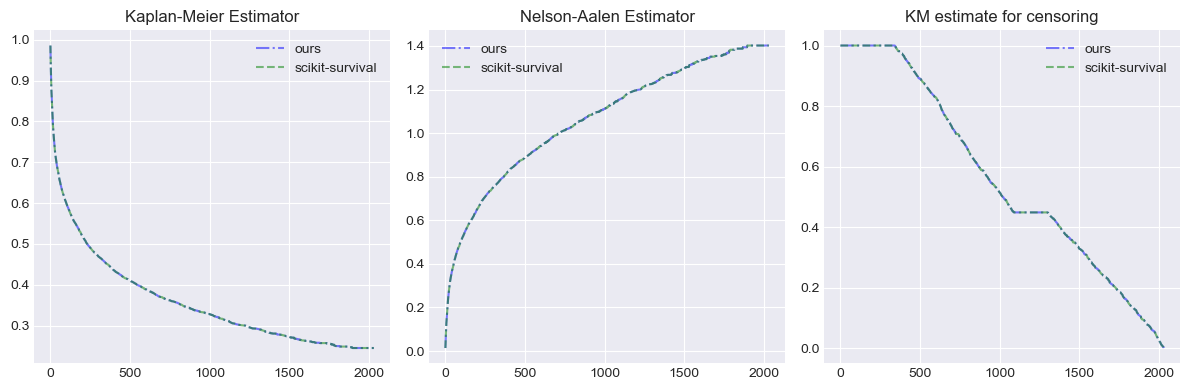

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].plot(*kaplan_meier(s_train, t_train)[:2], 'b-.', alpha=0.5, label='ours')
ax[0].plot(*kaplan_meier_estimator(s_train == 1, t_train), 'g--', alpha=0.5, label='scikit-survival')
ax[0].set_title('Kaplan-Meier Estimator')
ax[0].legend()

ax[1].plot(*nelson_aalen(s_train, t_train)[:2], 'b-.', alpha=0.5, label='ours')
ax[1].plot(*nelson_aalen_estimator(s_train == 1, t_train), 'g--', alpha=0.5, label='scikit-survival')
ax[1].set_title('Nelson-Aalen Estimator')
ax[1].legend()

ax[2].plot(*kaplan_meier(1 - s_train, t_train)[:2], 'b-.', alpha=0.5, label='ours')
ax[2].plot(*kaplan_meier_estimator(s_train == 0, t_train), 'g--', alpha=0.5, label='scikit-survival')
ax[2].set_title('KM estimate for censoring')
ax[2].legend()

plt.tight_layout()
plt.show()

# Verify CI and IPCW CI calculations against scikit-survival

In [4]:
pred_risk = CoxPHSurvivalAnalysis(alpha=.1).fit(
    x_train,
    Surv().from_arrays(s_train == 1, t_train)
).predict(x_test)

In [5]:
tau = None

print('CI (ours) = %.4f' % xCI(s_test, t_test, pred_risk))

print('CI (scikit-survival) = %.4f' % concordance_index_censored(
    s_test == 1, t_test, pred_risk)[0])

print('IPCW CI (ours) (estimate censoring from training set) = %.4f' % xCI(
    s_test, t_test, pred_risk, weights=ipc_weights(s_train, t_train, s_test, t_test, tau=tau)))

print('IPCW CI (scikit-survival) (estimate censoring from training set) = %.4f' % concordance_index_ipcw(
    Surv().from_arrays(s_train == 1, t_train),
    Surv().from_arrays(s_test == 1, t_test),
    pred_risk, tau=tau)[0])

print('IPCW CI (ours) (estimate censoring from test set) = %.4f' % xCI(
    s_test, t_test, pred_risk, weights=ipc_weights(s_test, t_test, s_test, t_test, tau=tau)))

print('IPCW CI (scikit-survival) (estimate censoring from test set) = %.4f' % concordance_index_ipcw(
    Surv().from_arrays(s_test == 1, t_test),
    Surv().from_arrays(s_test == 1, t_test),
    pred_risk, tau=tau)[0])

CI (ours) = 0.7476
CI (scikit-survival) = 0.7475
IPCW CI (ours) (estimate censoring from training set) = 0.7349
IPCW CI (scikit-survival) (estimate censoring from training set) = 0.7349
IPCW CI (ours) (estimate censoring from test set) = 0.7363
IPCW CI (scikit-survival) (estimate censoring from test set) = 0.7363


# Calculate xCI with and without IPCW

In [6]:
print('Without IPCW:')

for g1, l1 in zip([black_test, white_test], ['Black', 'White']):

    for g2, l2 in zip([black_test, white_test], ['Black', 'White']):

        print('xCI %s-%s = %.4f' % (
            l1, l2,
            xCI(
                s_test, t_test, pred_risk,
                pos_group=g1, neg_group=g2
            )
        ))

print()
print('With IPCW:')

for g1, l1 in zip([black_test, white_test], ['Black', 'White']):

    for g2, l2 in zip([black_test, white_test], ['Black', 'White']):

        print('xCI %s-%s = %.4f' % (
            l1, l2,
            xCI(
                s_test, t_test, pred_risk,
                weights=ipc_weights(s_train, t_train, s_test, t_test, tau='auto'),
                pos_group=g1, neg_group=g2
            )
        ))

Without IPCW:
xCI Black-Black = 0.7635
xCI Black-White = 0.7301
xCI White-Black = 0.7813
xCI White-White = 0.7426

With IPCW:
xCI Black-Black = 0.7532
xCI Black-White = 0.7183
xCI White-Black = 0.7710
xCI White-White = 0.7314


# Test xCI with bootstrapping

In [7]:
estimate, ci_low, ci_high = xCI(
    s_test, t_test, pred_risk,
    pos_group=g1, neg_group=g2,
    n_bootstrap_samples=30
)

print('xCI %s-%s = %.4f (%.4f - %.4f)' % (
    l1, l2,
    estimate,
    ci_low,
    ci_high
))

xCI White-White = 0.7426 (0.7345 - 0.7546)


# Test xAP<sub>t</sub> with bootstrapping

In [8]:
estimate, ci_low, ci_high = xAPt(
    s_test, t_test, pred_risk,
    times=np.array([1600]),
    pos_group=g1, neg_group=g2,
    n_bootstrap_samples=30
)

print('xAPt %s-%s = %.4f (%.4f - %.4f)' % (
    l1, l2,
    estimate,
    ci_low,
    ci_high
))

xAPt White-White = 0.9711 (0.9632 - 0.9751)


# Compute xAUC<sub>t</sub>, xROC<sub>t</sub>, xAP<sub>t</sub>, and xPR<sub>t</sub>

/Users/mme4/projects/tte-performance/measures.py:175: RuntimeWarning: invalid value encountered in divide
  return np.sum(correctly_ranked, axis=(0, 1)) / np.sum(valid, axis=(0, 1))


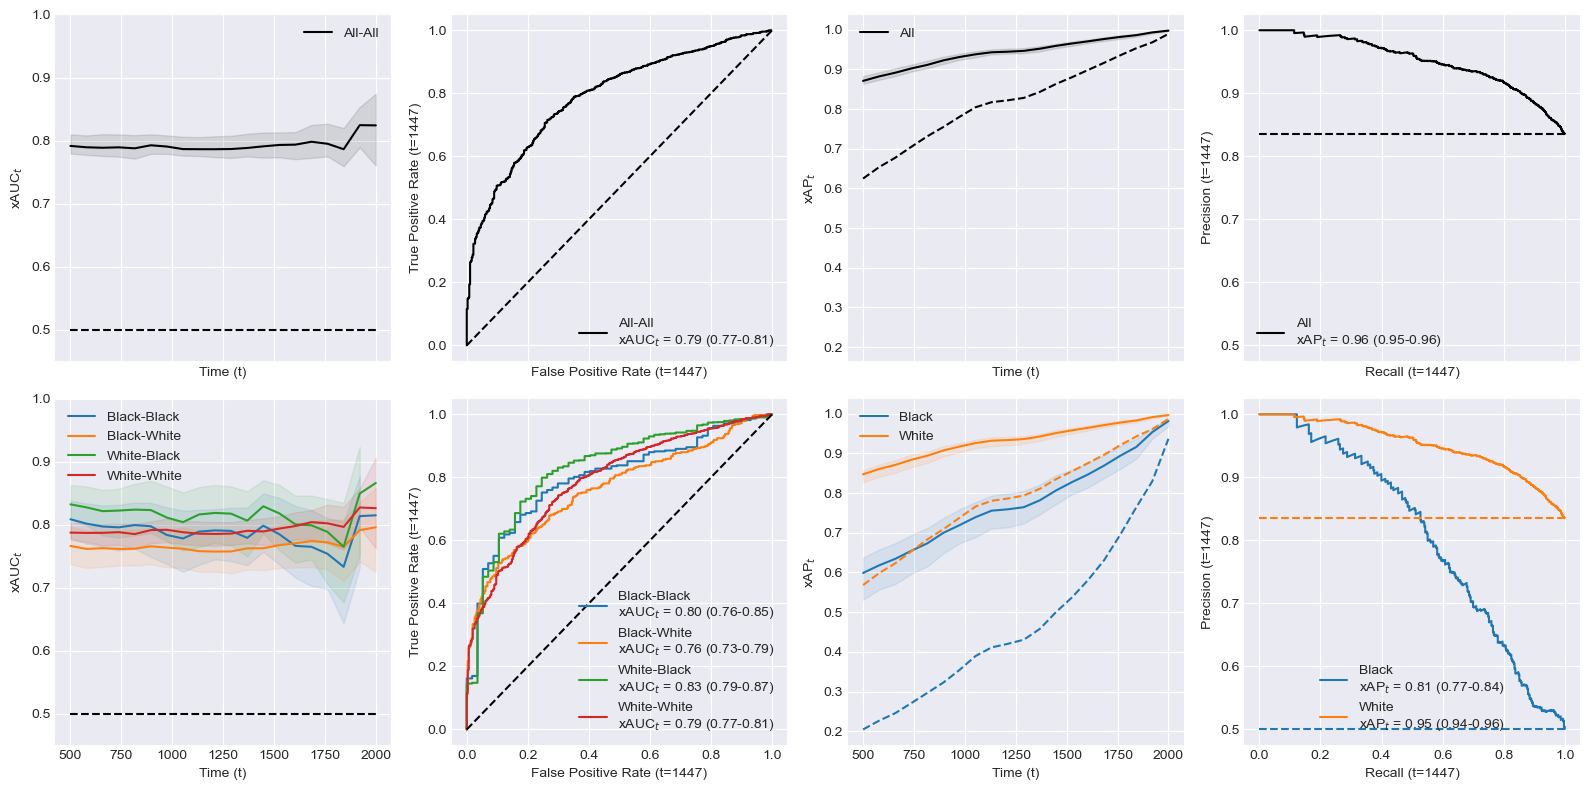

In [9]:
n_bootstrap_samples = 50

fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharey='col', sharex='col')

times = np.linspace(500, 2000, 20)
time_idx = 12
time = times[time_idx]

black_test = df['race_black'][test_idx:].values == 1
white_test = df['race_white'][test_idx:].values == 1

auct, ci_low, ci_high = xAUCt(
    s_test, t_test, pred_risk, times,
    pos_group=black_test | white_test,
    neg_group=black_test | white_test,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[0, 0].plot(times, auct, 'k-', label='All-All')
ax[0, 0].fill_between(times, ci_low, ci_high, color='k', alpha=.1)

tprt, fprt, _ = xROCt(
    s_test, t_test, pred_risk, time,
    pos_group=black_test | white_test,
    neg_group=black_test | white_test
)

ax[0, 1].plot(
    fprt, tprt, 'k-',
    label='All-All\nxAUC$_t$ = %.2f (%.2f-%.2f)' % (
        auct[time_idx], ci_low[time_idx], ci_high[time_idx]
    )
)

(apt, prevt), (apt_low, prev_low), (apt_high, prev_high) = xAPt(
    s_test, t_test, pred_risk, times,
    pos_group=black_test | white_test,
    neg_group=black_test | white_test,
    return_prevalence=True,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[0, 2].plot(times, apt, 'k-', label='All')
ax[0, 2].fill_between(times, apt_low, apt_high, color='k', alpha=.1)
ax[0, 2].plot(times, prevt, 'k--')#, label='Prevalence at t')

recallt, precisiont, _, prevt = xPRt(
    s_test, t_test, pred_risk, time,
    pos_group=g1
)

ax[0, 3].plot(
    recallt, precisiont, 'k-',
    label='All\nxAP$_t$ = %.2f (%.2f-%.2f)' % (
        apt[time_idx], apt_low[time_idx], apt_high[time_idx]
    )
)

ax[0, 3].plot([0, 1], [prevt, prevt], 'k--')#, label='Prevalence at t')

for g1, l1 in zip([black_test, white_test], ['Black', 'White']):
    
    for g2, l2 in zip([black_test, white_test], ['Black', 'White']):
        
        auct, ci_low, ci_high = xAUCt(
            s_test, t_test, pred_risk, times,
            pos_group=g1,
            neg_group=g2,
            n_bootstrap_samples=n_bootstrap_samples
        )

        p = ax[1, 0].plot(times, auct, label='%s-%s' % (l1, l2))
        ax[1, 0].fill_between(times, ci_low, ci_high, color=p[0].get_color(), alpha=.1)

        tprt, fprt, _ = xROCt(
            s_test, t_test, pred_risk, time,
            pos_group=g1,
            neg_group=g2
        )

        ax[1, 1].plot(
            fprt, tprt,
            label='%s-%s\nxAUC$_t$ = %.2f (%.2f-%.2f)' % (
                l1, l2, auct[time_idx], ci_low[time_idx], ci_high[time_idx]
            )
        )

    (apt, prevt), (apt_low, prev_low), (apt_high, prev_high) = xAPt(
        s_test, t_test, pred_risk, times,
        pos_group=g1,
        return_prevalence=True,
        n_bootstrap_samples=n_bootstrap_samples
    )

    p = ax[1, 2].plot(times, apt, label='%s' % l1)
    ax[1, 2].fill_between(times, apt_low, apt_high, color=p[0].get_color(), alpha=.1)
    ax[1, 2].plot(times, prevt, '--', color=p[0].get_color())#, label='Prevalence at t')

    recallt, precisiont, _, prevt = xPRt(
        s_test, t_test, pred_risk, time,
        pos_group=g1
    )

    p = ax[1, 3].plot(
        recallt, precisiont,
        label='%s\nxAP$_t$ = %.2f (%.2f-%.2f)' % (
            l1, apt[time_idx], apt_low[time_idx], apt_high[time_idx]
        )
    )
    
    ax[1, 3].plot([0, 1], [prevt, prevt], '--', color=p[0].get_color())#, label='Prevalence at t')

for i in range(2):

    ax[i, 0].plot(times, times * 0 + .5, 'k--')
    ax[i, 0].set_ylim([0.45, 1.])
    ax[i, 0].set_ylabel('xAUC$_t$')
    ax[i, 0].set_xlabel('Time (t)')
    ax[i, 0].legend()

    ax[i, 1].plot([0, 1], [0, 1], 'k--')
    ax[i, 1].set_ylabel('True Positive Rate (t=%i)' % time)
    ax[i, 1].set_xlabel('False Positive Rate (t=%i)' % time)
    ax[i, 1].legend()
    
    ax[i, 2].set_ylabel('xAP$_t$')
    ax[i, 2].set_xlabel('Time (t)')
    ax[i, 2].legend()
    
    ax[i, 3].set_ylabel('Precision (t=%i)' % time)
    ax[i, 3].set_xlabel('Recall (t=%i)' % time)
    ax[i, 3].legend()

plt.tight_layout()
plt.show()